In [91]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib
%matplotlib inline

# Import Data

In [92]:
# Create training and testing dataframes
train_df = pd.read_csv('kc_house_data_train.csv')
holdout_df = pd.read_csv('kc_house_data_test_features.csv')

# Modeling

In [93]:
# Print column names
print(train_df.keys())

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [94]:
# Function to create age and renovation age range columns
def set_ages(df):
    ren_age = df['yr_renovated']
    ren = ren_age != 0
    df['ren_5'] = np.where(ren & (ren_age>2010), 1, 0)
    df['ren_10'] = np.where((ren_age>2005) & (ren_age<2011), 1, 0)
    df['ren_15'] = np.where((ren_age>2000) & (ren_age<2005), 1, 0)
    df['ren_old'] = np.where(ren & (ren_age<2000), 1, 0)
    df['age'] = 2015 - df['yr_built']
    return None

# Transform bedrooms outliers in dataframes 
set_ages(train_df)
set_ages(holdout_df)

In [98]:
train_df['ren_5'].sort_values(ascending=False)

860      1
1289     1
12465    1
2627     1
13619    1
6292     1
14912    1
3091     1
3090     1
7658     1
3088     1
6614     1
7910     1
13098    1
13101    1
16842    1
2610     1
3076     1
732      1
8180     1
6856     1
736      1
5025     1
4790     1
948      1
2083     1
13017    1
4992     1
2098     1
4448     1
        ..
11522    0
11521    0
11520    0
11519    0
11518    0
11517    0
11516    0
11515    0
11514    0
11513    0
11512    0
11511    0
11510    0
11509    0
11508    0
11507    0
11506    0
11505    0
11504    0
11503    0
11502    0
11501    0
11500    0
11499    0
11498    0
11497    0
11496    0
11495    0
11494    0
0        0
Name: ren_5, Length: 17290, dtype: int64

In [25]:
# Create year dummy variables for training dataframe
train_df['year'] = train_df['date'].apply(lambda x: int(x[0:4]))
d_years = pd.get_dummies(train_df['year'], drop_first=True)
train_df = pd.concat([train_df, d_years], axis=1)
train_df.drop('year', axis=1, inplace=True)

train_df.keys()

Index([   'Unnamed: 0',            'id',          'date',         'price',
            'bedrooms',     'bathrooms',   'sqft_living',      'sqft_lot',
              'floors',    'waterfront',          'view',     'condition',
               'grade',    'sqft_above', 'sqft_basement',      'yr_built',
        'yr_renovated',       'zipcode',           'lat',          'long',
       'sqft_living15',    'sqft_lot15',   'newly_built',            2015],
      dtype='object')

In [26]:
# # Function for creating year dummy variables
# def set_years(df):
#     df['year'] = df['date'].apply(lambda df: int(df[0:4]))
#     d_years = pd.get_dummies(train_df['year'], drop_first=True)
#     df = pd.concat([df, d_years], axis=1)
#     df.drop('year', axis=1, inplace=True)
#     return None

# # Create year dummy variables for dataframes
# set_years(train_df)
# set_years(holdout_df)

In [27]:
# Create month dummy variables for training dataframe
months = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun',
          7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
train_df['month'] = train_df['date'].apply(lambda x: int(x[4:6]))
d_months = pd.get_dummies(train_df['month'], drop_first=True)
for key in d_months.keys():
    if key in months.keys():
        d_months.rename({key : months[key]}, axis=1, inplace=True)
train_df = pd.concat([train_df, d_months], axis=1)
train_df.drop('month', axis=1, inplace=True)

train_df.keys()

Index([   'Unnamed: 0',            'id',          'date',         'price',
            'bedrooms',     'bathrooms',   'sqft_living',      'sqft_lot',
              'floors',    'waterfront',          'view',     'condition',
               'grade',    'sqft_above', 'sqft_basement',      'yr_built',
        'yr_renovated',       'zipcode',           'lat',          'long',
       'sqft_living15',    'sqft_lot15',   'newly_built',            2015,
                 'feb',           'mar',           'apr',           'may',
                 'jun',           'jul',           'aug',           'sep',
                 'oct',           'nov',           'dec'],
      dtype='object')

In [28]:
# # Function for creating month dummy variables
# def set_months(df):
#     months = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun',
#               7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
#     df['month'] = df['date'].apply(lambda x: int(x[4:6]))
#     d_months = pd.get_dummies(df['month'], drop_first=True)
#     for key in d_months.keys():
#         if key in months.keys():
#             d_months.rename({key : months[key]}, axis=1, inplace=True)
#     df = pd.concat([df, d_months], axis=1)
#     df.drop('month', axis=1, inplace=True)
#     return df

# # Create month dummy variables for dataframes
# set_months(train_df, train_ignore)
# set_months(holdout_df, holdout_ignore)

In [29]:
# # Function for creating year zipcode variables
# def set_zipcodes(df):
#     for zipcode in df['zipcode'].unique():
#         df[str(zipcode)] = np.where(df['zipcode'] == zipcode, 1, 0)
#     df.drop('year', axis=1, inplace=True)
#     return None

# # Create zipcode dummy variables for dataframes
# set_years(train_df)
# set_years(holdout_df)

In [30]:
# Function to transform bedrooms outliers
def bedrooms_trans(df):
    filt = df['bedrooms'] < 10
    df['bedrooms'] = np.where(filt, df['bedrooms'], 10)
    return None

# Transform bedrooms outliers in dataframes 
bedrooms_trans(train_df)
bedrooms_trans(holdout_df)

In [31]:
# Function to transform bathrooms outliers
def bathrooms_trans(df):
    low_filt = df['bathrooms'] > .5
    df['bathrooms'] = np.where(low_filt, df['bathrooms'], .5)
    high_filt = df['bathrooms'] < 5
    df['bathrooms'] = np.where(high_filt, df['bathrooms'], 5)
    return None

# Transform bedrooms outliers in dataframes 
bathrooms_trans(train_df)
bathrooms_trans(holdout_df)

# Create Params

In [32]:
# Print column names
print(train_df.keys())

Index([   'Unnamed: 0',            'id',          'date',         'price',
            'bedrooms',     'bathrooms',   'sqft_living',      'sqft_lot',
              'floors',    'waterfront',          'view',     'condition',
               'grade',    'sqft_above', 'sqft_basement',      'yr_built',
        'yr_renovated',       'zipcode',           'lat',          'long',
       'sqft_living15',    'sqft_lot15',   'newly_built',            2015,
                 'feb',           'mar',           'apr',           'may',
                 'jun',           'jul',           'aug',           'sep',
                 'oct',           'nov',           'dec'],
      dtype='object')


In [33]:
# Function to create features list
def set_features(df):
    ignore = ['Unnamed: 0', 'id', 'price', 'date', 'yr_built', 'yr_renovated',
              'zipcode', 'lat', 'long', 'sqft_living']
    features = list(df.keys())
    for feature in ignore:
        if feature in features:
            features.remove(feature)
    return features

# Create features list for dataframes
train_features = set_features(train_df)
holdout_features = set_features(holdout_df)

# EDA

In [34]:
# Print features list
print(train_features)

['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'newly_built', 2015, 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']


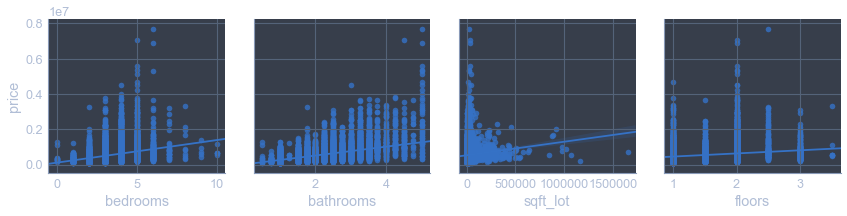

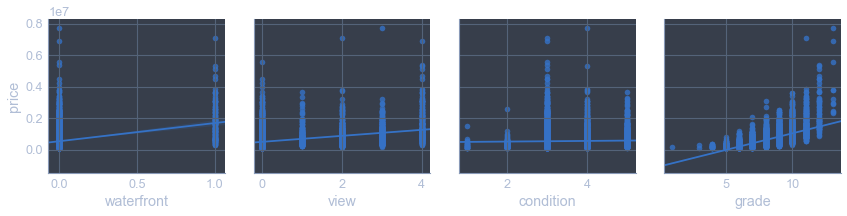

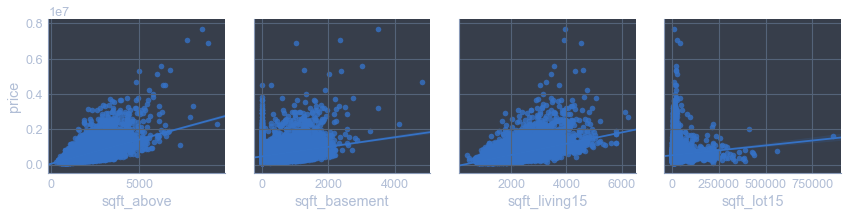

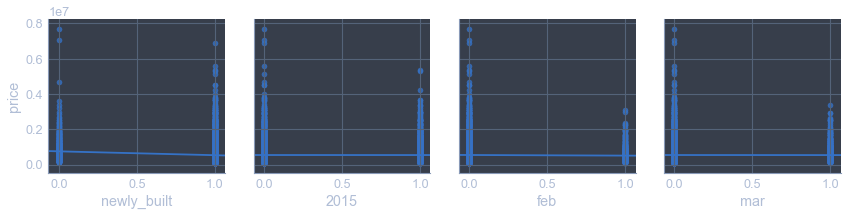

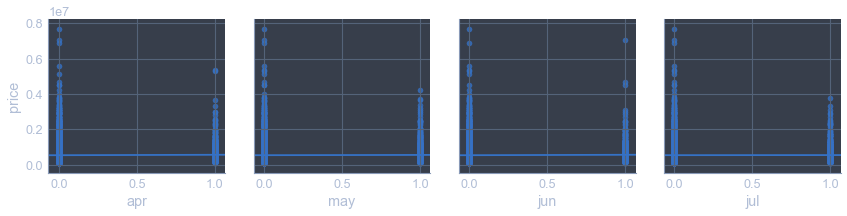

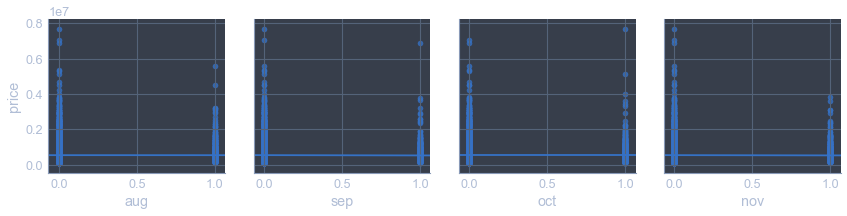

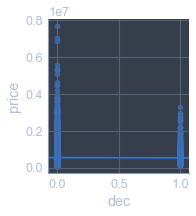

In [15]:
# Function to create feature pplots
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['price'], x_vars=row, kind='reg', height=3)
    return None

# Create feature pplots for training df
pplot_features(train_df, train_features)

# Run Model

In [35]:
# Print features list
print(train_features)

['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'newly_built', 2015, 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']


In [39]:
# Function to create regression model
def set_model(df, features):
    model = sm.OLS(df['price'], sm.add_constant(
        df[[key for key in TESTING_FEATURES]])).fit()
    return model.summary()

# Run model on training dataframe
set_model(train_df, train_features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2247.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        13:28:29   Log-Likelihood:            -2.3824e+05
No. Observations:               17290   AIC:                         4.765e+05
Df Residuals:                   17277   BIC:                         4.766e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.925e+05   1.98e+04    -35.042      0.000   -7.31e+05   -6.54e+05
bedrooms      -3.689e+04   2517.804    -14.653      0.000   -4.18e+04    -3.2e+04
bathrooms     -2.733e+04   3952.727     -6.915      0.000   -3.51e+04   -1.96e+04
sqft_lot          0.0217      0.059      0.366      0.714      -0.094       0.138
floors          686.5765   4529.950      0.152      0.880   -8192.585    9565.738
waterfront     5.947e+05   2.19e+04     27.139      0.000    5.52e+05    6.38e+05
view           5.833e+04   2694.322     21.651      0.000    5.31e+04    6.36e+04
condition      5.478e+04   2855.256     19.184      0.000    4.92e+04    6.04e+04
grade          1.011e+05   2693.037     37.553      0.000    9.59e+04    1.06e+05
sqft_above      198.7232      4.660     42.647      0.000     189.590     207.857
sqft_basement   228.8998      5.478     41.782      0.000     218.161     239.638
sqft_living15    10.8514      4.334      2.504      0.012       2.356      19.347
sqft_lot15       -0.7395      0.093     -7.986      0.000      -0.921      -0.558
==============================================================================
Omnibus:                    13023.070   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           855943.003
Skew:                           3.048   Prob(JB):                         0.00
Kurtosis:                      36.926   Cond. No.                     6.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Notes (TESTING)

In [41]:
# Recreate original dataframe without any added columns
TESTING = pd.read_csv('kc_house_data_train.csv')

# Create features list for original dataframe
TESTING_FEATURES = set_features(TESTING)

# Run model on original dataframe
set_model(TESTING, TESTING_FEATURES)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     2235.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        13:29:53   Log-Likelihood:            -2.3827e+05
No. Observations:               17290   AIC:                         4.766e+05
Df Residuals:                   17277   BIC:                         4.767e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.989e+05   1.97e+04    -35.526      0.000   -7.37e+05    -6.6e+05
bedrooms      -3.453e+04   2403.132    -14.370      0.000   -3.92e+04   -2.98e+04
bathrooms     -1.696e+04   3929.181     -4.317      0.000   -2.47e+04   -9259.702
sqft_lot          0.0237      0.059      0.399      0.690      -0.093       0.140
floors        -3659.7055   4524.986     -0.809      0.419   -1.25e+04    5209.725
waterfront     5.968e+05   2.19e+04     27.192      0.000    5.54e+05     6.4e+05
view            5.88e+04   2698.104     21.795      0.000    5.35e+04    6.41e+04
condition      5.498e+04   2860.438     19.220      0.000    4.94e+04    6.06e+04
grade          1.005e+05   2691.904     37.322      0.000    9.52e+04    1.06e+05
sqft_above      193.1497      4.677     41.298      0.000     183.982     202.317
sqft_basement   221.0182      5.501     40.178      0.000     210.236     231.801
sqft_living15    10.5564      4.342      2.431      0.015       2.045      19.068
sqft_lot15       -0.7294      0.093     -7.865      0.000      -0.911      -0.548
==============================================================================
Omnibus:                    13209.164   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           909371.834
Skew:                           3.103   Prob(JB):                         0.00
Kurtosis:                      37.982   Cond. No.                     6.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Unused Functions

In [76]:
# # Function to create target variable
# def set_target(df):
#     target = df['price']
#     return target

# # Create target variable for dataframes
# train_target = set_target(train_df)
# test_target = set_target(test_df)

In [77]:
# # Function for creating year dummy variables
# def set_years(df, ignore_features):
#     df['year'] = df['date'].apply(lambda x: int(x[0:4]))
#     for year in df['year'].unique():
#         df[str(year)] = np.where(df['year'] == year, 1, 0)
#     df.drop('year', axis=1, inplace=True)
#     ignore_features.append(year)
#     return None

# # Create year dummy variables for dataframes
# set_years(train_df, train_ignore)
# set_years(holdout_df, holdout_ignore)

In [78]:
# # Function for creating month dummy variables
# def set_months(df, ignore_features):
#     ignore_month = None
#     df['month'] = df['date'].apply(lambda x: int(x[4:6]))
#     for month in df['month'].unique():
#         df[str(month)] = np.where(df['month'] == month, 1, 0)
#     columns = {'1':'jan', '2':'feb', '3':'mar', '4':'apr', '5':'may', '6':'jun',
#               '7':'jul', '8':'aug', '9':'sep', '10':'oct', '11':'nov', '12':'dec'}
#     df.rename(columns, axis=1, inplace=True)
#     df.drop('month', axis=1, inplace=True)
#     ignore_features.append(month)
#     return None

# # Create month dummy variables for dataframes
# set_months(train_df, train_ignore)
# set_months(holdout_df, holdout_ignore)

In [79]:
# # Filter extreme values
# def ext_values(df, extreme_cols):
#     new_df = df.copy()
#     for col in extreme_cols:
#         std = new_df[col].std()
#         mean = new_df[col].mean()
#         value = mean+(4*std)
#         new_df[col] = new_df[col].apply(lambda x: value if (x > 4*std) else x)
#     return new_df

In [40]:
# # Function to create regression model
# def set_model(df, features):
#     formula = 'price~' + '+'.join([f'{ft}' for ft in features])
#     model = smf.ols(formula=formula, data=df).fit()
#     return model.summary()

# # Run model on train dataframe
# set_model(train_df, train_features)